# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import time

tempo_agora = time.time() # Tempo inicial

## 0.1 Loading Datasets

In [2]:
billiard = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\bar_sales_forecast\\data\\raw\\billiard.csv', )
sales = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\bar_sales_forecast\\data\\raw\\sales.csv')

In [3]:
billiard.head(5)

,#No,Name,#Start Time,In Use,Semana,Turno,Total Bilhar,Pago,#Preço/Hora,Data
0,848,***Quarta1***,1/00:45,0:15,5,Noite,2.0,2.00,3.5,5/31/2017
1,829,Guest(30),31/18:06,6:24,5,Tarde,0.0,24.60,0.0,5/31/2017
2,836,Guest(28),31/20:46,4:28,5,Tarde,0.0,4.50,0.0,5/31/2017
3,838,Guest(27),31/20:57,3:25,5,Tarde,0.0,29.72,0.0,5/31/2017
4,844,Guest(14),31/22:16,2:47,5,Noite,0.0,48.30,0.0,5/31/2017


In [4]:
sales.head(5)

,#Time,Purchaser,Item,#Voucher,Semana,Turno,Classe 1,Classe 2,Classe 3,Preço,Total Venda,Data,Quantidade
0,2/23:50:26,Mesa 1,10%,150,1,Noite,Gorjeta,NaN,NaN,0.1,1.6,5/2/2017,16
1,2/23:56:18,Mesa 5,10%,151,1,Noite,Gorjeta,NaN,NaN,0.1,3.7,5/2/2017,37
2,3/00:43:47,Mesa 1,10%,153,1,Noite,Gorjeta,NaN,NaN,0.1,1.5,5/2/2017,15
3,3/01:04:07,Mesa 5,10%,155,1,Noite,Gorjeta,NaN,NaN,0.1,2.4,5/2/2017,24
4,3/00:43:35,Mesa 1,Agua s/ Gás,153,1,Noite,Bar,Sem Álcool,NaN,3.0,6.0,5/2/2017,2


## 0.2 Helper Functions

# 1.0 Data Description

## 1.1 Data Dimensions

In [5]:
print(f'Billiard qty of rows: {billiard.shape[0]}')
print(f'Billiard qty of columns: {billiard.shape[1]}')
print()
print(f'Sales qty of rows: {sales.shape[0]}')
print(f'Sales qty of columns: {sales.shape[1]}')

Billiard qty of rows: 44264
Billiard qty of columns: 10

Sales qty of rows: 135057
Sales qty of columns: 13


## 1.2 Datatype

In [6]:
print('billiard\n')
billiard.dtypes

billiard



#No               int64
Name             object
#Start Time      object
In Use           object
Semana            int64
Turno            object
Total Bilhar    float64
Pago            float64
#Preço/Hora     float64
Data             object
dtype: object

In [7]:
print('sales\n')
sales.dtypes

sales



#Time           object
Purchaser       object
Item            object
#Voucher         int64
Semana           int64
Turno           object
Classe 1        object
Classe 2        object
Classe 3        object
Preço          float64
Total Venda    float64
Data            object
Quantidade       int64
dtype: object

## 1.3 Check NaN values

In [8]:
print('billiard\n')
billiard.isna().sum()

billiard



#No             0
Name            0
#Start Time     0
In Use          0
Semana          0
Turno           0
Total Bilhar    0
Pago            0
#Preço/Hora     0
Data            0
dtype: int64

In [9]:
print('sales\n')
sales.isna().sum()

sales



#Time              0
Purchaser      12271
Item               0
#Voucher           0
Semana             0
Turno              0
Classe 1        2328
Classe 2       18733
Classe 3       74084
Preço              0
Total Venda        0
Data               0
Quantidade         0
dtype: int64

O sistema gestor de vendas utilizado tem uma modalidade de vendas que não vincula o produto à uma mesa de consumo, geralmente utilizados quando ocorre uma venda avulsa, que é paga no ato da compra. Tais produtos são inseridos no sistema sem informação no campo "Purchaser", o que justifica os 8930 NaN Values nessa feature. As features Classe 2 e Classe 3 possuem NaN Values porque alguns produtos são cadastrados e classificados apenas no primeiro nível (Classe 1).

## 1.4 Data Cleaning

In [10]:
# billiard

# Adjusting #Start Time to datetimeindex format
billiard['start_time'] = billiard['#Start Time'].apply(lambda x: x.split('/')[1])

# Adjusting #Data to datetime format
billiard['Data'] = billiard['Data'].str.replace('/', '-').str.strip()

# Creating datetime feature with datetime dtype
billiard['datetime'] = billiard['Data'] + '-' + billiard['start_time']
billiard['datetime'] = pd.to_datetime(billiard['datetime'])

# Changing interesting feature names
billiard.rename(columns={'#No':'id'}, inplace=True)
billiard.rename(columns={'Name':'purchaser'}, inplace=True)
billiard.rename(columns={'Total Bilhar':'sale'}, inplace=True)
billiard.rename(columns={'#Preço/Hora':'price'}, inplace=True)
billiard.rename(columns={'Semana':'week'}, inplace=True)
billiard.rename(columns={'Turno':'work_shift'}, inplace=True)
billiard.rename(columns={'In Use':'in_use'}, inplace=True)

#  Creating quantity feature
billiard['quantity'] = round(billiard['sale'] / billiard['price'], 1)

# Creating item feature
billiard['item'] = 'bilhar'

# Droping features
billiard.drop(['Pago', 'Data', 'start_time', '#Start Time'], axis=1, inplace=True)

# sales

# Catch date informations
sales['Time'] = sales['#Time'].apply(lambda x: x.split('/')[1])
sales['datetime'] = sales['Data'] + '-' + sales['Time']

# Creating datetime feature
sales['datetime'] = pd.to_datetime(sales['datetime'])

# Changing interesting feature names
sales.rename(columns={'#Voucher':'id'}, inplace=True)
sales.rename(columns={'Total Venda':'sale'}, inplace=True)
sales.rename(columns={'Preço':'price'}, inplace=True)
sales.rename(columns={'Classe 1':'class1'}, inplace=True)
sales.rename(columns={'Semana':'week'}, inplace=True)
sales.rename(columns={'Turno':'work_shift'}, inplace=True)
sales.rename(columns={'Purchaser':'purchaser'}, inplace=True)
sales.rename(columns={'Item':'item'}, inplace=True)
sales.rename(columns={'Quantidade':'quantity'}, inplace=True)

# Removing features
sales.drop(['#Time', 'Data', 'Time', 'Classe 2', 'Classe 3'], axis=1, inplace=True)

## 1.5 Creating Dataframe

In [11]:
# concating
df1 = pd.concat([billiard, sales], axis=0)

# Pivoting table to date x class1
df1.loc[df1['class1'].isnull(), 'class1'] = 'Bilhar'
df1['datetime'] = pd.to_datetime(df1['datetime'])
df1['date'] = df1['datetime'].dt.date
df1['date'] = pd.to_datetime(df1['date'])
df1 = df1.pivot_table(columns='class1', index='date', values='sale', aggfunc='sum', fill_value=0)
df1['total'] = df1.sum(axis=1)

## 1.6 Data Dimensions

In [12]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 1402
Number of columns: 7


## 1.7 Check NaN values

In [13]:
df1.isnull().sum()

class1
Bar           0
Bilhar        0
Bomboniere    0
Cozinha       0
Gorjeta       0
Tabacaria     0
total         0
dtype: int64

## 1.8 Descriptive Statistics

In [14]:
# central tendency
ct1 = pd.DataFrame(df1.apply(np.mean)).T
ct2 = pd.DataFrame(df1.apply(np.median)).T
# dispersion
d1 = pd.DataFrame(df1.apply(np.std)).T
d2 = pd.DataFrame(df1.apply(np.min)).T
d3 = pd.DataFrame(df1.apply(np.max)).T
d4 = pd.DataFrame(df1.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df1.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df1.apply(lambda x: x.kurtosis())).T

# Concat
temp = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T
temp.columns = 'min max range mean median std skew kurtosis'.split()
temp

,min,max,range,mean,median,std,skew,kurtosis
class1,,,,,,,,
Bar,0.0,3150.89,3150.89,867.100492,711.685,531.183137,0.879389,0.200127
Bilhar,0.0,1694.05,1694.05,301.890934,245.700,221.691692,1.635786,3.677141
Bomboniere,0.0,60.00,60.00,5.150856,3.000,6.599463,2.365360,9.175608
Cozinha,0.0,1332.10,1332.10,277.452568,231.350,201.674061,1.097061,1.318658
Gorjeta,0.0,315.10,315.10,68.753709,51.150,57.899959,1.002113,0.467568
Tabacaria,0.0,253.50,253.50,31.366098,22.000,34.381868,1.703922,3.804228
total,0.0,5284.59,5284.59,1551.714658,1262.905,931.576013,0.798690,-0.138506


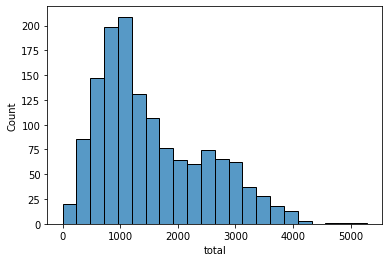

In [15]:
sns.histplot(data=df1, x='total');

# 2.0 Feature Engineering

In [16]:
df2 = df1.copy()

In [17]:
# Day of week
df2 = df2.resample('d').sum()
df2['day_of_week'] = df2.index.day_name()
remover = df2.loc[df2['day_of_week']=='Monday'].index
df2.drop(remover, axis=0, inplace=True)

# Shifted values
df2['shift_1'] = df2['total'].shift(1)
df2['shift_2'] = df2['total'].shift(2)
df2['shift_3'] = df2['total'].shift(3)
df2['shift_5'] = df2['total'].shift(5)
df2['shift_6'] = df2['total'].shift(6)
df2['shift_11'] = df2['total'].shift(11)
df2['shift_12'] = df2['total'].shift(12)
shifteds = 'shift_1 shift_2 shift_3 shift_5 shift_6 shift_11 shift_12'.split()

# 3.0 Business Hypothesis

In [18]:
df3 = df2.copy()

# 4.0 Exploratory Data Analysis 

In [19]:
df4 = df3.copy()

## 4.1 Amount by the Time

### 4.1.1 Decompose

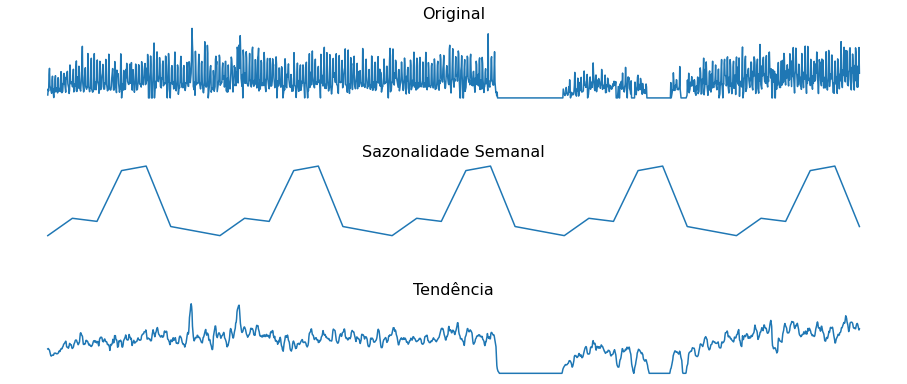

In [20]:
decomp = seasonal_decompose(df4['total'], period=6)

plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace = 0.8)
plt.subplot(4, 1, 1)
ax = decomp.observed.plot()
ax.tick_params(bottom=False, labelbottom=False, labelleft=False, left=False)
plt.title('Original', fontsize=16)
plt.xlabel('')
plt.subplot(4, 1, 2)
ax = decomp.seasonal[-30:].plot()
ax.tick_params(bottom=False, labelbottom=False, labelleft=False, left=False)
plt.title('Sazonalidade Semanal', fontsize=16)
plt.xlabel('')
plt.subplot(4, 1, 3)
ax = decomp.trend.plot()
ax.tick_params(bottom=False, labelbottom=False, labelleft=False, left=False)
plt.title('Tendência', fontsize=16)
sns.despine(left=True, bottom=True)
plt.xlabel('');

* Sazonalidades semanais bem definidas.
* A tendência foi afetada pelo período sem funcionamento, causado pela Covid 19

### 4.1.2 Autocorrelation

D:\My Drive\Pessoal\environments\data_science\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


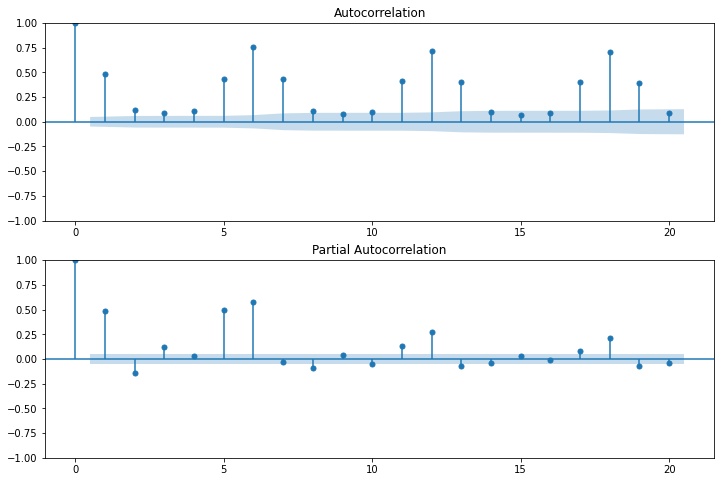

In [21]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df4['total'] , lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df4['total'] , lags=20, ax=ax2)

Há autocorrelação com uma boa margem de confiança os lags 1, 2, 3, 5, 6, 11 e 12 (o 4 não está incluso)

### 4.1.3 Weekly Sales

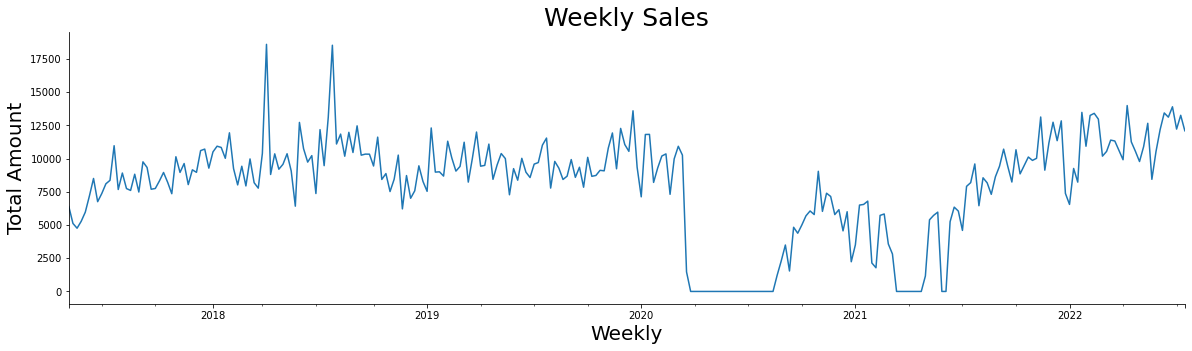

In [22]:
plt.figure(figsize=(20, 5))
df4.resample('w').sum()['total'].plot()
plt.title('Weekly Sales', fontsize=25)
plt.xlabel('Weekly', fontsize=20)
plt.ylabel('Total Amount', fontsize=20)
sns.despine();

## 4.2 Univariate

## 4.3 Bivariate

## 4.4 Multivariate

# 5.0 Data Filtering

In [23]:
df5 = df4.copy()

In [24]:
# rows

# columns


# 6.0 Data Preparation

In [25]:
df6 = df5.copy()

## 6.1 Normalization

## 6.2 Rescaling

## 6.3 Response Variable

## 6.4 Transformations

### 6.4.1 Encodings

### 6.4.2 Nature Transformations

## 6.5 Splits

# 7.0 Machine Learning Modeling

In [26]:
df7 = df6.copy()

# 8.0 Model Performance

In [27]:
df8 = df7.copy()

## 8.1 Machine Learning Performance

## 8.2 Business Performance

# 9.0 Exportings

# 10.0 Deploy

## 10.1 Top_bar_class

## 10.2 Handler API

## 10.3 API Tester

# Time

In [28]:
print(f'O projeto está processando em {round((time.time() - tempo_agora) / 60, 2)} minutos')

O projeto está processando em 0.25 minutos
